# marti benchmarking

This notebook will use the Callao outputs generated in notebook 03 (monomer analysis) to compare and benchmark `marti` against a few other tools. We are using the monomer data because we will be running both `marti` and `restrander` twice on all the data, and 3 out of 4 runs will be on a single thread for benchmarking purposes. Running it on the smaller dataset will make this faster, but the same comparison could be performed on the MAS-seq data just the same.

`restrander` can be installed by following the instructions in their github: https://github.com/mritchielab/restrander?tab=readme-ov-file#installation

In [1]:
import re
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import yaml

from mdl.sc_isoform_paper import today
from mdl.sc_isoform_paper.constants import MONOMER_KEYS
from mdl.sc_isoform_paper.marti import CONFIG_DICT, SAMPLE_CONFIG
from mdl.sc_isoform_paper.marti_benchmark import summarize_input, summarize_many, collapse_marti_ct, plot_absolute, plot_heatmap, plot_upset_from_ct, plot_upset_from_per_input_df
import warnings

In [ ]:
root_dir = Path.home()
sh_dir = root_dir / "sh_scripts"

data_path = root_dir / "data" / "monomer"
figure_path = root_dir / "202501_figures"

# path to the marti binary
marti_bin = root_dir / "marti/build/bin/marti"

# path to restrander binary
restrander_dir = root_dir / "restrander"
restrander_bin = restrander_dir / "restrander"
restrander_config = restrander_dir / "config"

# path for marti output
marti_path = data_path / f"{today}_marti_benchmarks"
marti_path.mkdir(exist_ok=True)

# path for GNU Time output
logs_dir = root_dir / "benchmark_logs"
logs_dir.mkdir(exist_ok=True)

# paths for input files, the output from callao
callao_bams = sorted((data_path / "callao").glob("*bam"))
callao_bams


In [3]:
default_polya_len = { "min_polyA_match": 20 }
single_core = {"n_threads": 1}

RESTRANDER_CONFIG = {
    "PIPseq": restrander_config / "PIPseq.json",  # does not exist, we will create it
    "10x 3'": restrander_config / "10X-5prime.json",
    "10x 5'": restrander_config / "10X-3prime.json",
}

# Since restrander is initially intended for ONT data, the error rate in their configs are rather high,
# so we will create an alternate version of the provided 10X configs where we reduce the error rate to 0.05, 
# raise the polyA length to 20, and set the search size to 150 to match settings with marti
RESTRANDER_PB_CONFIG = {
    "PIPseq": restrander_config / "PIPseq_PB.json",
    "10x 3'": restrander_config / "10X-5prime_PB.json",
    "10x 5'": restrander_config / "10X-3prime_PB.json",
}

In [4]:
with open(RESTRANDER_CONFIG["PIPseq"], "w") as out:
    out.write("""{
    "name": "PIPseq",
    "description": "Uses PIPseq primers.",
    "pipeline": [
        {
            "type": "poly",
            "tail-length": 12,
            "search-size": 200
        },
        {
            "type": "primer",
            "tso": "AAGCAGTGGTATCAACGCAGAG",
            "rtp": "CTACACGACGCTCTTCCGATCT",
            "report-artefacts": true
        }
    ],
    "silent": false,
    "exclude-unknowns": true,
    "error-rate": 0.25
}
""")

with open(RESTRANDER_PB_CONFIG["PIPseq"], "w") as out:
    out.write("""{
    "name": "PIPseq PB",
    "description": "Uses PIPseq primers.",
    "pipeline": [
        {
            "type": "poly",
            "tail-length": 20,
            "search-size": 150
        },
        {
            "type": "primer",
            "tso": "AAGCAGTGGTATCAACGCAGAG",
            "rtp": "CTACACGACGCTCTTCCGATCT",
            "report-artefacts": true
        }
    ],
    "silent": false,
    "exclude-unknowns": true,
    "error-rate": 0.05
}
""")

with open(RESTRANDER_PB_CONFIG["10x 3'"], "w") as out:
    out.write("""{
    "name": "10X 3' PB",
    "description": "Uses 10X 3' primers.",
    "pipeline": [
        {
            "type": "poly",
            "tail-length": 20,
            "search-size": 150
        },
        {
            "type": "primer",
            "tso": "AAGCAGTGGTATCAACGCAGAGTAC",
            "rtp": "CTACACGACGCTCTTCCGATCT",
            "report-artefacts": true
        }
    ],
    "silent": false,
    "exclude-unknowns": true,
    "error-rate": 0.05
}
""")

with open(RESTRANDER_PB_CONFIG["10x 5'"], "w") as out:
    out.write("""{
    "name": "10X 5' PB",
    "description": "Uses 10X 5' primers.",
    "pipeline": [
        {
            "type": "poly",
            "tail-length": 20,
            "search-size": 150
        },
        {
            "type": "primer",
            "tso": "CTACACGACGCTCTTCCGATCT",
            "rtp": "AAGCAGTGGTATCAACGCAGAGTAC",
            "report-artefacts": true
        }
    ],
    "silent": false,
    "exclude-unknowns": true,
    "error-rate": 0.05
}
""")

Prepare the Marti run configs and commands. This is basically the same runs as intially done in notebook 03, but we measure resources and time with `GNU Time`.
Besides that, to run `restrander` we need FASTQs, so we will extract them from the BAMs using samtools.

In [5]:
with open(sh_dir / f"{today}_monomer_marti_benchmark.sh", "w") as out, \
     open(sh_dir / f"{today}_monomer_marti_8t_benchmark.sh", "w") as out_8t, \
     open(sh_dir / f"{today}_monomer_fastq_restrander.sh", "w") as out2, \
     open(sh_dir / f"{today}_monomer_restrander_benchmark.sh", "w") as out3, \
     open(sh_dir / f"{today}_monomer_restrander_PB_benchmark.sh", "w") as out4:

    for cb in callao_bams:
        i = int(cb.name.split(".")[2])
        mp = marti_path / cb.stem
    
        # make a run directory for each file
        mp.mkdir(exist_ok=True, parents=True)
        config_file = mp / "config.yaml"

        # write config file with appropriate parameters
        with open(config_file, "w") as out_yaml:
            print(
                yaml.dump(
                    {"input_bam": str(cb)}
                    | SAMPLE_CONFIG[MONOMER_KEYS[i][0]]
                    | CONFIG_DICT
                    | default_polya_len 
                    | single_core,
                    sort_keys=False
                ),
                file=out_yaml
            )

        print(f"/usr/bin/time -v {marti_bin} {config_file} 2> {logs_dir}/time_marti_{cb.stem}.log",
              file=out)

        mp = marti_path / (cb.stem + "_8t")
        mp.mkdir(exist_ok=True, parents=True)
        config_file = mp / "config.yaml"
        with open(config_file, "w") as out_yaml:
            print(
                yaml.dump(
                    {"input_bam": str(cb)}
                    | SAMPLE_CONFIG[MONOMER_KEYS[i][0]]
                    | CONFIG_DICT
                    | default_polya_len,
                    sort_keys=False
                ),
                file=out_yaml
            )

        print(f"/usr/bin/time -v {marti_bin} {config_file} 2> {logs_dir}/time_marti_8t_{cb.stem}.log",
              file=out_8t)

        print(f"samtools fastq -@ 2 {mp}/{cb.stem}.classified.bam -0 {fastq_path}/{cb.stem}.marti_tags.fastq",
              file=out2)

        print(f"/usr/bin/time -v {restrander_bin} {fastq_path}/{cb.stem}.marti_tags.fastq {restrander_path}/{cb.stem}.restrander.fastq.gz {RESTRANDER_CONFIG[MONOMER_KEYS[i][0]]} > {restrander_path}/{cb.stem}.restrander-stats.json 2> {logs_dir}/time_restrander_{cb.stem}.log",
              file=out3)

        print(f"/usr/bin/time -v {restrander_bin} {fastq_path}/{cb.stem}.marti_tags.fastq {restrander_path}/{cb.stem}.restrander_PB.fastq.gz {RESTRANDER_PB_CONFIG[MONOMER_KEYS[i][0]]} > {restrander_path}/{cb.stem}.restrander_PB-stats.json 2> {logs_dir}/time_restrander_PB_{cb.stem}.log",
              file=out4)


We now need to run the scripts generated externally.

After that, we can parse the timing logs.

In [6]:
TIME_AT_END = re.compile(r'(\d+(?::\d{2}){1,2}(?:\.\d+)?)\s*$')
FNAME_RE = re.compile(r'^time_(?P<tool>marti(?:_\d+t)?|restrander(?:_PB)?)_(?P<input>.+)\.log$')

def parse_fname(p: Path):
    m = FNAME_RE.match(p.name)
    if not m:
        raise ValueError(f"Unexpected filename: {p.name}")
    return m.group('tool'), m.group('input')

def parse_elapsed_line(line: str) -> float:
    m = TIME_AT_END.search(line)
    token = m.group(1)
    parts = token.split(":")
    s = float(parts[-1])
    m_ = int(parts[-2]) if len(parts) >= 2 else 0
    h = int(parts[-3]) if len(parts) == 3 else 0
    return h*3600 + m_*60 + s

def parse_time_log(path: Path) -> dict:
    data = {}
    with open(path) as fh:
        for raw in fh:
            line = raw.strip()
            if line.startswith("User time"):
                data["user_time"] = float(line.rsplit(":", 1)[1].strip())
            elif line.startswith("System time"):
                data["sys_time"] = float(line.rsplit(":", 1)[1].strip())
            elif line.startswith("Elapsed (wall clock) time"):
                data["real_time"] = parse_elapsed_line(line)
    return data


rows = []
for log in logs_dir.glob("time_*.log"):
    tool, input_name = parse_fname(log)
    stats = parse_time_log(log)
    if stats:
        rows.append({"tool": tool, "input": input_name, **stats})

df = pd.DataFrame(rows)
df["cpu_time"] = df["user_time"] + df["sys_time"]

# wide table
pivot = df.pivot(index="input", columns="tool", values=["cpu_time", "real_time"])
pivot.columns = [f"{metric}_{tool}" for metric, tool in pivot.columns]
pivot = pivot.reset_index()

print(pivot)

                             input  cpu_time_marti  cpu_time_marti_8t  \
0   m64455e_230922_195123.callao.1          182.67             185.88   
1   m64455e_230922_195123.callao.2          181.05             277.43   
2   m64455e_230922_195123.callao.3          166.16             283.57   
3   m64455e_230922_195123.callao.4          203.84             304.12   
4   m64455e_230922_195123.callao.5          179.35             282.22   
5   m64455e_230922_195123.callao.6          199.62             207.65   
6   m64455e_230924_064453.callao.1          185.77             189.00   
7   m64455e_230924_064453.callao.2          183.70             188.82   
8   m64455e_230924_064453.callao.3          162.34             166.25   
9   m64455e_230924_064453.callao.4          203.00             207.25   
10  m64455e_230924_064453.callao.5          174.90             177.50   
11  m64455e_230924_064453.callao.6          208.90             205.36   

    cpu_time_restrander  cpu_time_restrander_PB  r

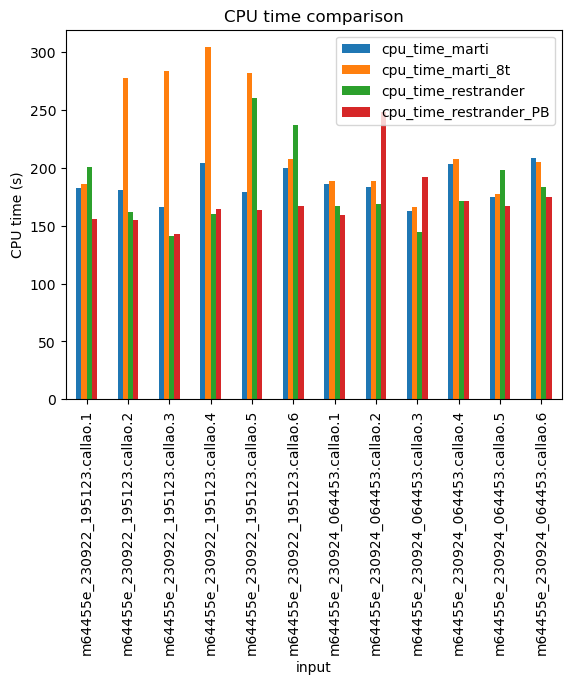

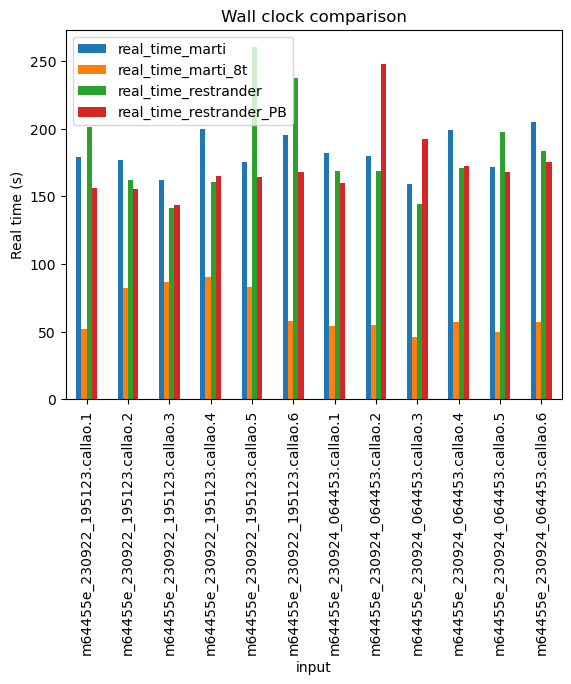

In [7]:
# Absolute times
pivot.plot.bar(x="input", y=["cpu_time_marti", "cpu_time_marti_8t", "cpu_time_restrander", "cpu_time_restrander_PB"])
plt.ylabel("CPU time (s)")
plt.title("CPU time comparison")
plt.show()

pivot.plot.bar(x="input", y=["real_time_marti", "real_time_marti_8t", "real_time_restrander", "real_time_restrander_PB"])
plt.ylabel("Real time (s)")
plt.title("Wall clock comparison")
plt.show()


In [8]:
tidy = (
    df[["input", "tool", "cpu_time", "real_time"]]
    .melt(id_vars=["input", "tool"], var_name="metric", value_name="seconds")
)

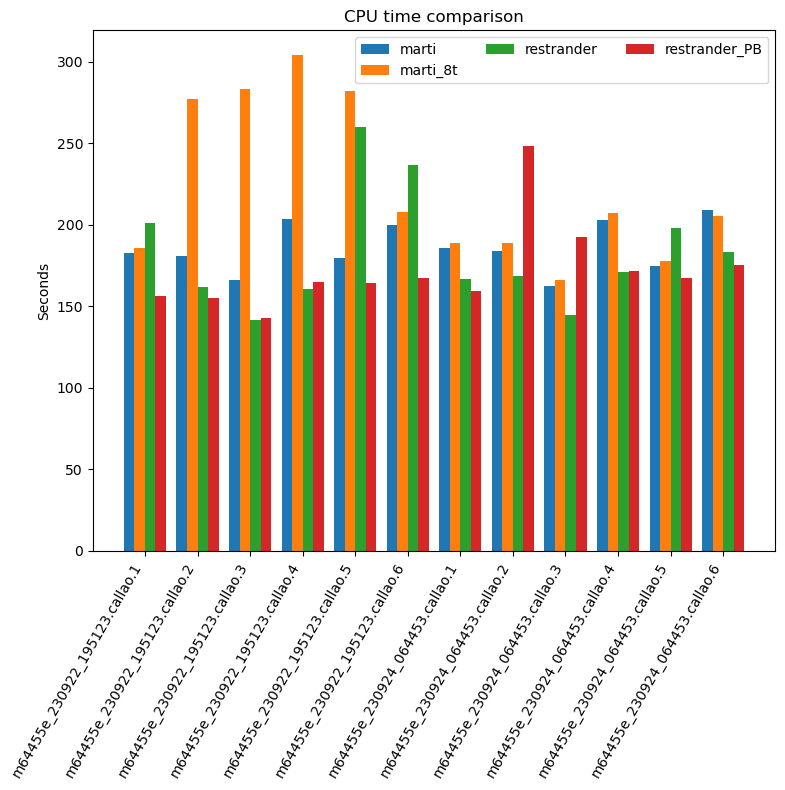

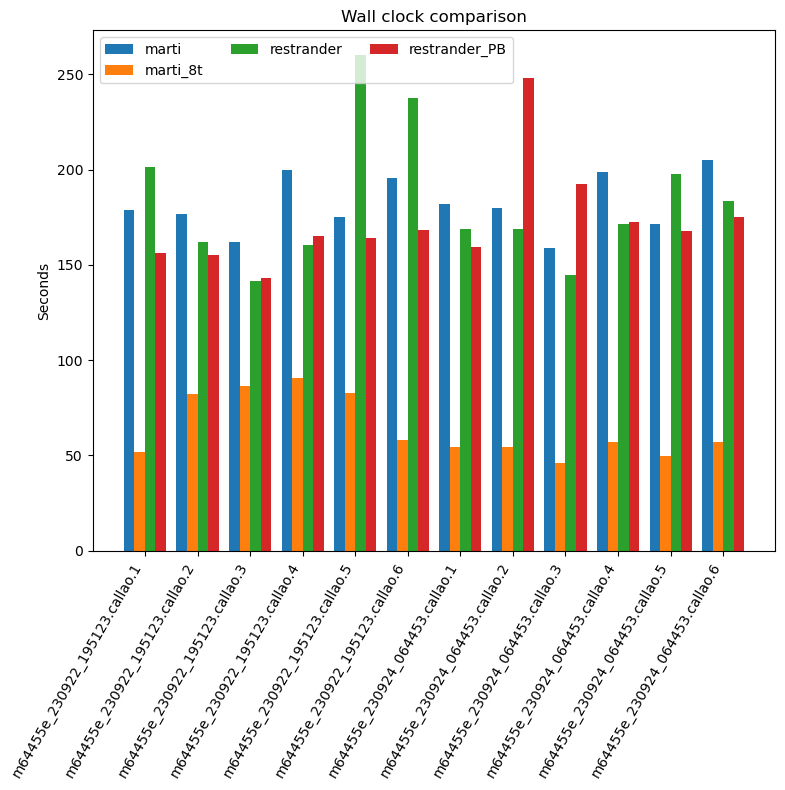

In [9]:
plot_absolute(tidy, metric="cpu_time",  title="CPU time comparison") #,  savepath="abs_cpu.svg")
plot_absolute(tidy, metric="real_time", title="Wall clock comparison") # savepath="abs_real.svg")

We will now compare the artefact classifications of both tools. For `marti` we read the "lb" tag. Because `marti` reports more categories than restrander, we will collapse those extra categories into "Other" to simplify the comparison.

For `restrander`, there are 2 outputs. One with all the "proper" reads restranded, and one with artefacts and unknowns. We will use the lower error rate version because the default error rate leads to incorrect TSO/RT matches.

We can first look at the comparison for one sample.

In [10]:
df_reads, ct = summarize_input(callao_bams[0].stem, marti_root=marti_path, restrander_root=restrander_path)
print(ct)  # counts per category pair

Restrander                        Proper  RtRt  TsoTso  Unk
Marti                                                      
InternalAdapter                      374    47     227    0
InternalAdapter,MissingAdapter        14     0       0    2
InternalAdapter,RetainedSMRTBell      71     6      55    0
InternalPrimingRT                   2428     0       0    0
InternalPrimingTSO                  1330     0      60    0
MissingAdapter                      3442     0       0  332
MissingAdapter,OnlyPolyA             138     0       0    1
OnlyPolyA                          51745     0       0    0
Proper                            678853     0       0    0
RetainedSMRTBell                       3     0       0    0
RtRt                                  37    26       0    0
TooShort                            7266     0       0    0
TsoTso                              2201     0    1448    0
Unk                                  118     1      14    0


We can now visualize the category matches as a heatmap or an upset plot.

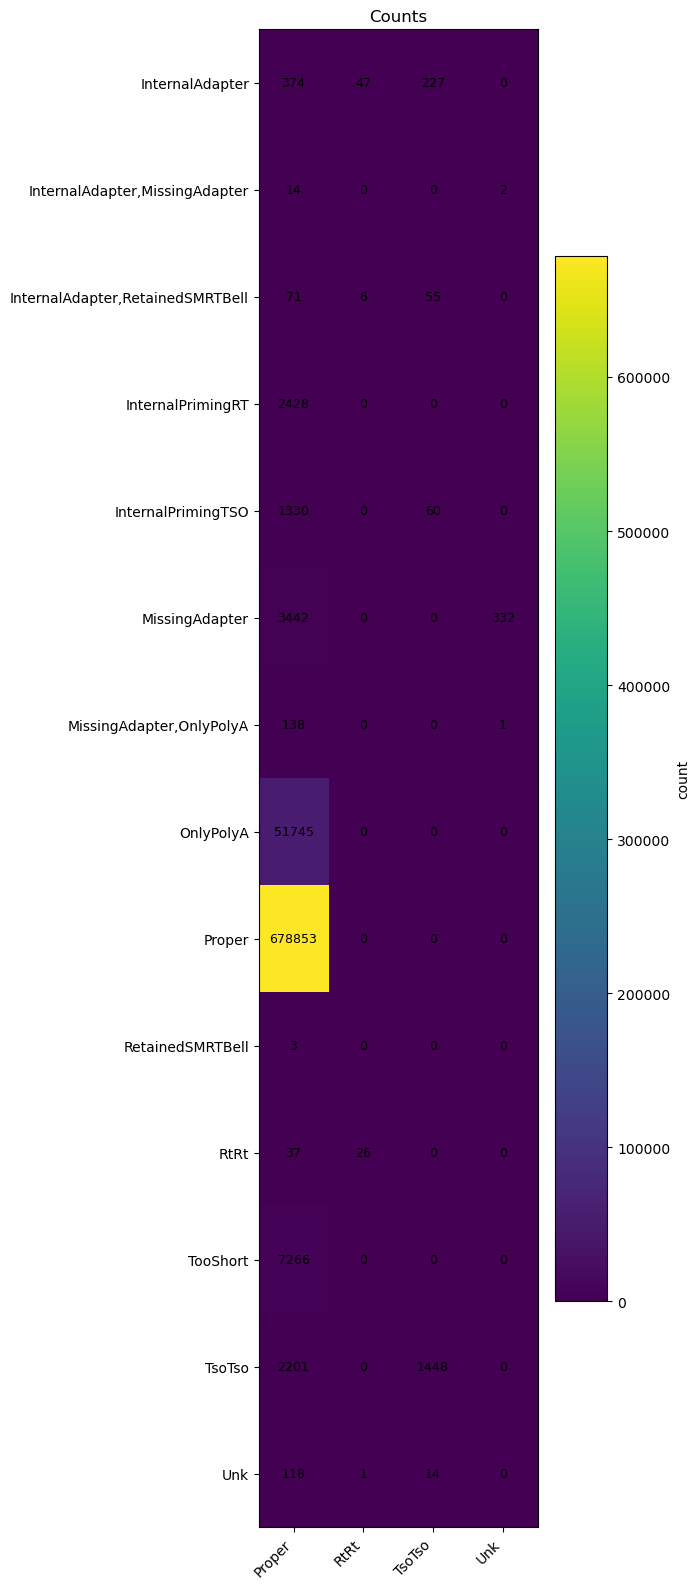

In [11]:
plot_heatmap(ct, normalize=None,  title="Counts") #,            savepath="heat_counts.svg")

In [16]:
warnings.filterwarnings("ignore") # pandas outputs some warning about future compatibility changes

/home/unix/cgeorges/.conda/envs/mdl-sc-isoform-2025-ms/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/mnt/data/github/mdl-sc-isoform-paper/src/mdl/sc_isoform_paper/marti_benchmark.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


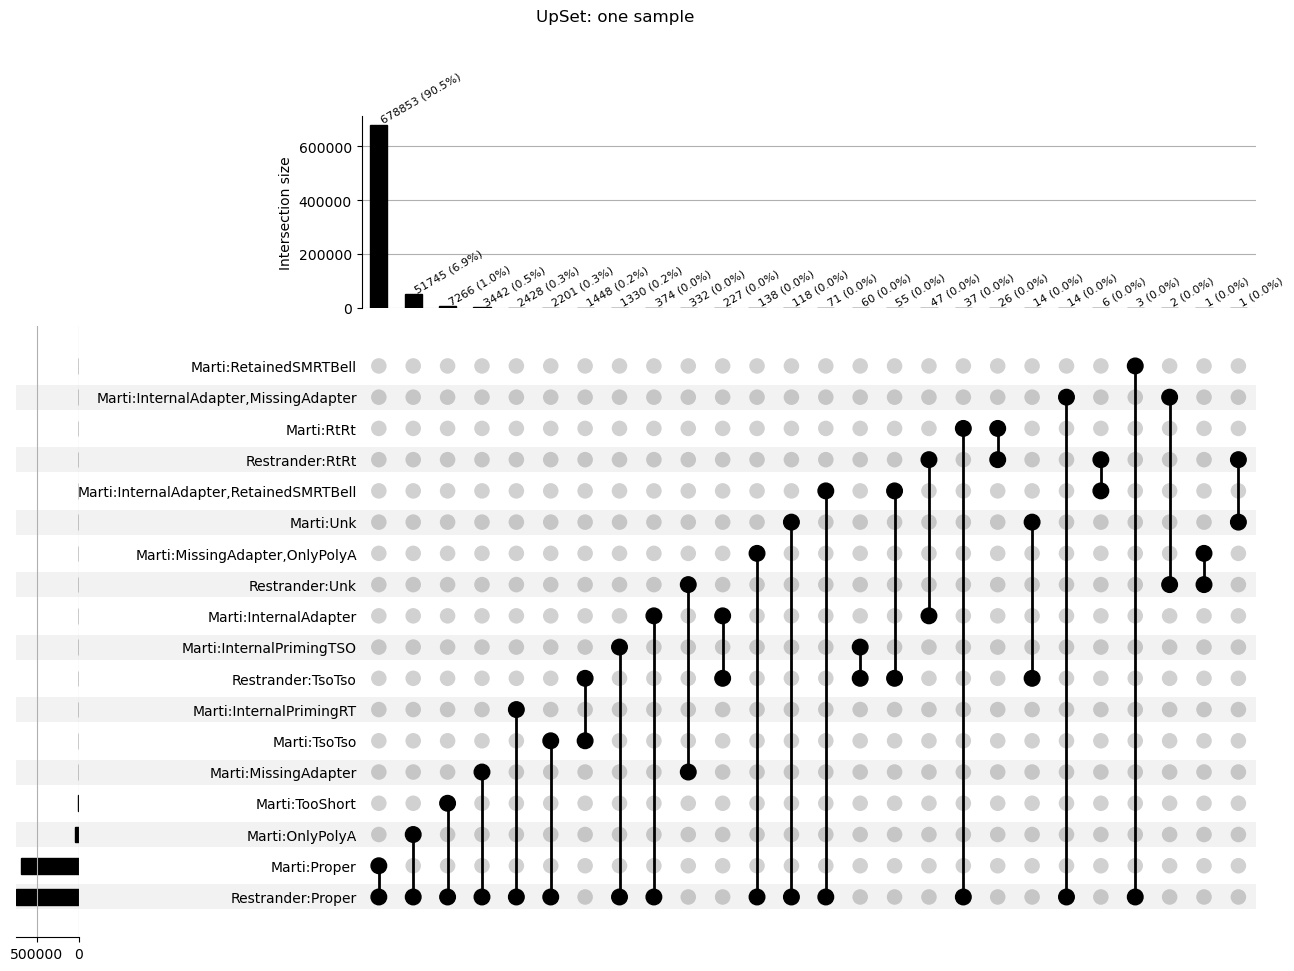

In [12]:
plot_upset_from_ct(ct, title="UpSet: one sample")

This is however a bit messy to look at because `marti` has a number of categories that `restrander` does not, so for simplicity we can also collapse all the `marti` extra categories into an "Other" group.

In [13]:
ct_collapsed = collapse_marti_ct(ct)

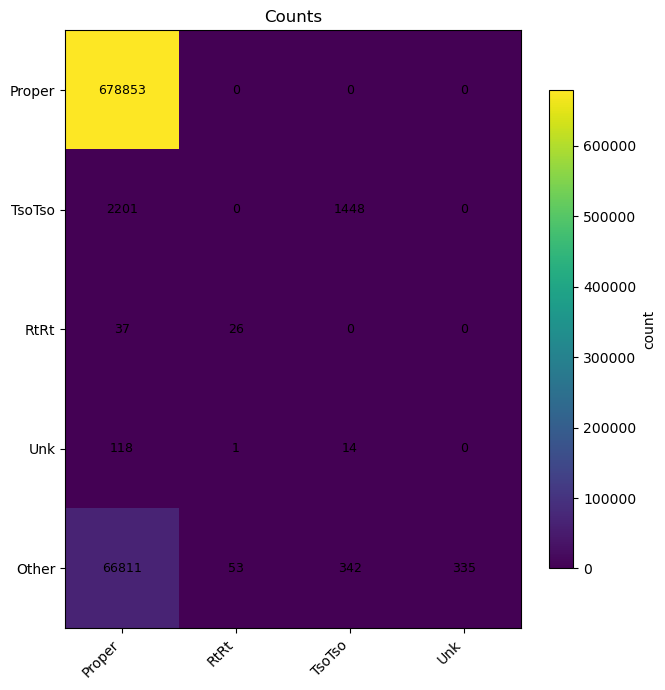

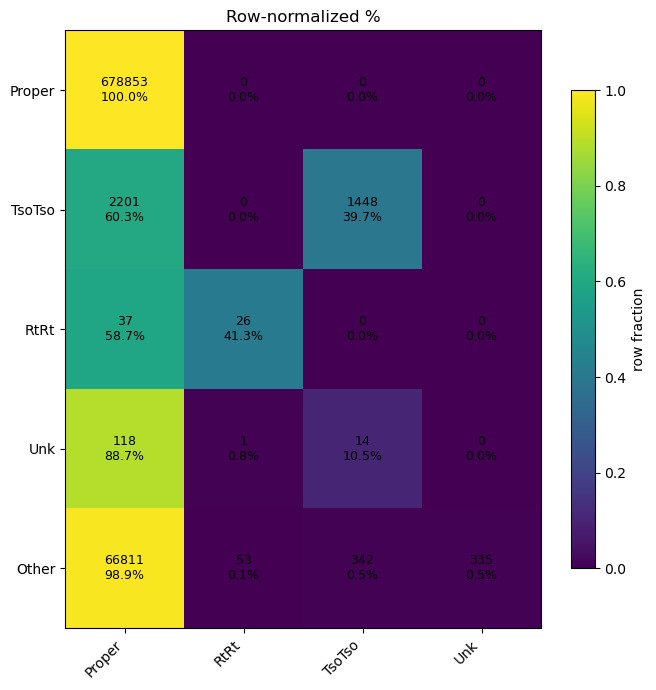

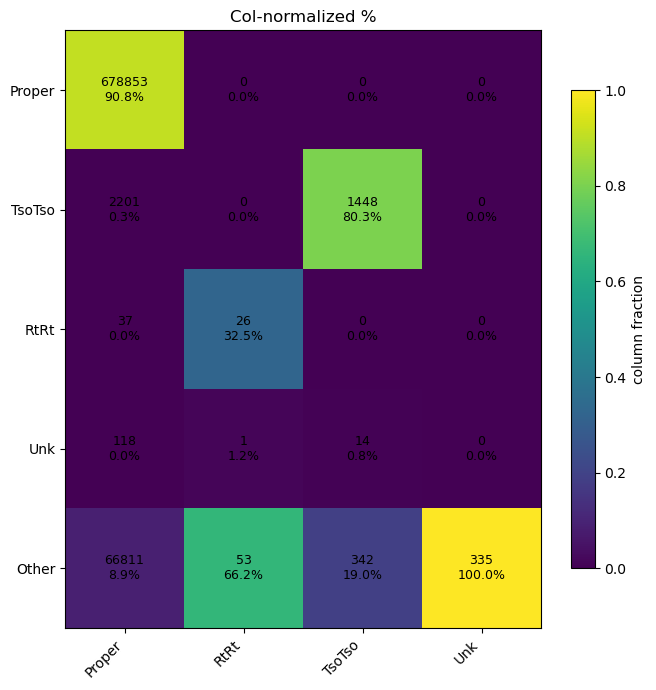

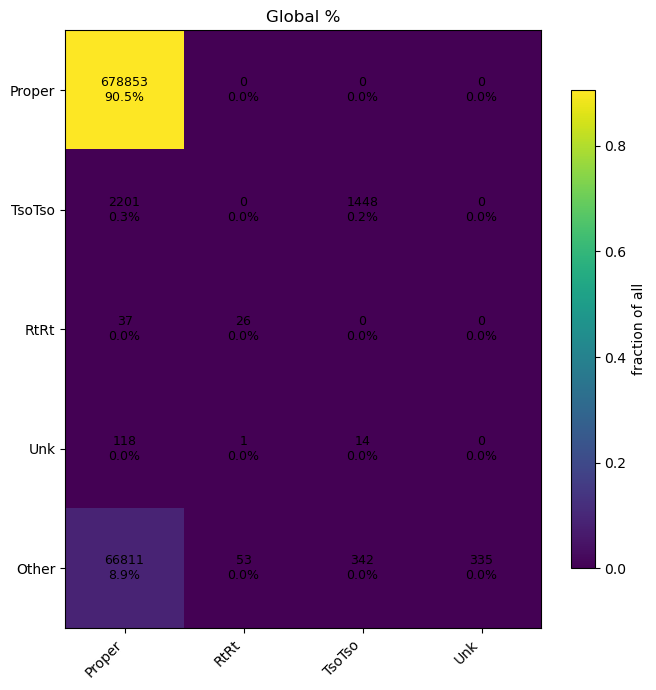

In [14]:
plot_heatmap(ct_collapsed, normalize=None,  title="Counts") #,            savepath="heat_counts.svg")
plot_heatmap(ct_collapsed, normalize='row', title="Row-normalized %") #,  savepath="heat_row.svg")
plot_heatmap(ct_collapsed, normalize='col', title="Col-normalized %") #,  savepath="heat_col.svg")
plot_heatmap(ct_collapsed, normalize='all', title="Global %") #,          savepath="heat_all.svg")

/home/unix/cgeorges/.conda/envs/mdl-sc-isoform-2025-ms/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/mnt/data/github/mdl-sc-isoform-paper/src/mdl/sc_isoform_paper/marti_benchmark.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


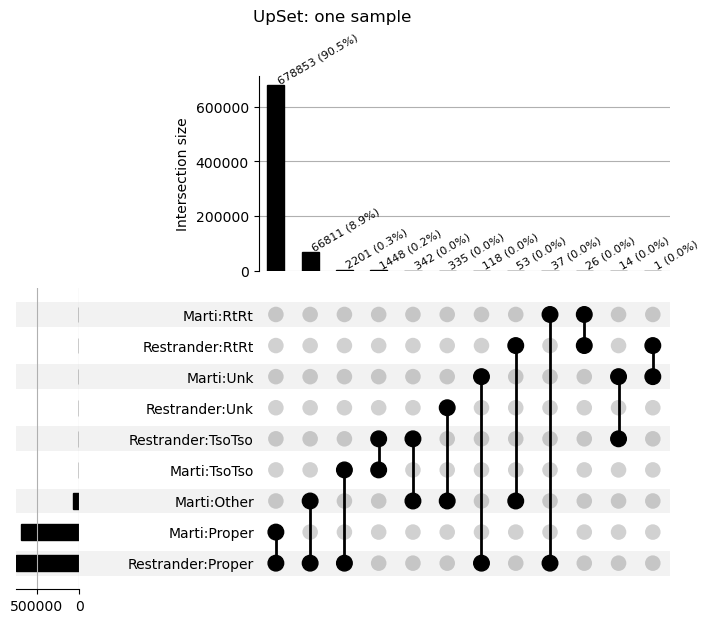

In [15]:
plot_upset_from_ct(ct_collapsed, title="UpSet: one sample")

We can now get overall stats across all libraries and flowcells.

In [17]:
per_input_df, agg_ct = summarize_many(base_names=[cb.stem for cb in callao_bams], marti_root=marti_path, restrander_root=restrander_path)

Again we will collapse the extra categories here to simplify the visualization, but you can run the plotting methods with just `agg_ct` instead of `agg_ct_collapsed` just fine.

In [18]:
agg_ct_collapsed = collapse_marti_ct(agg_ct)

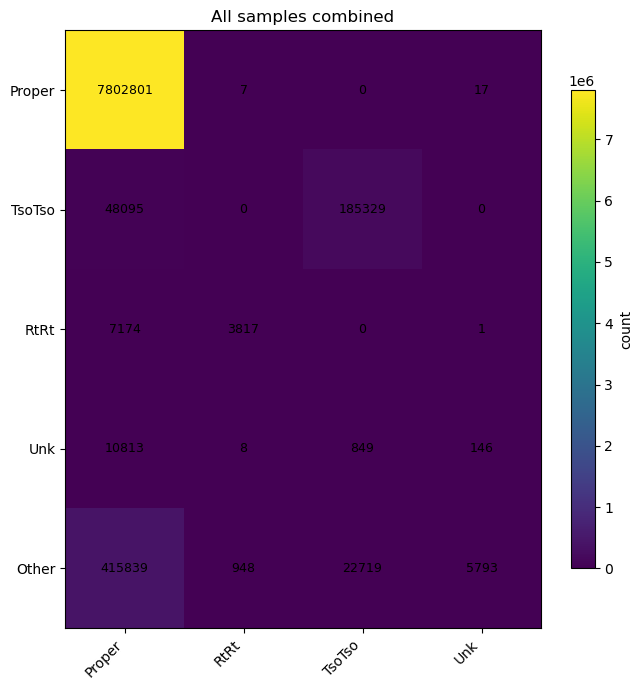

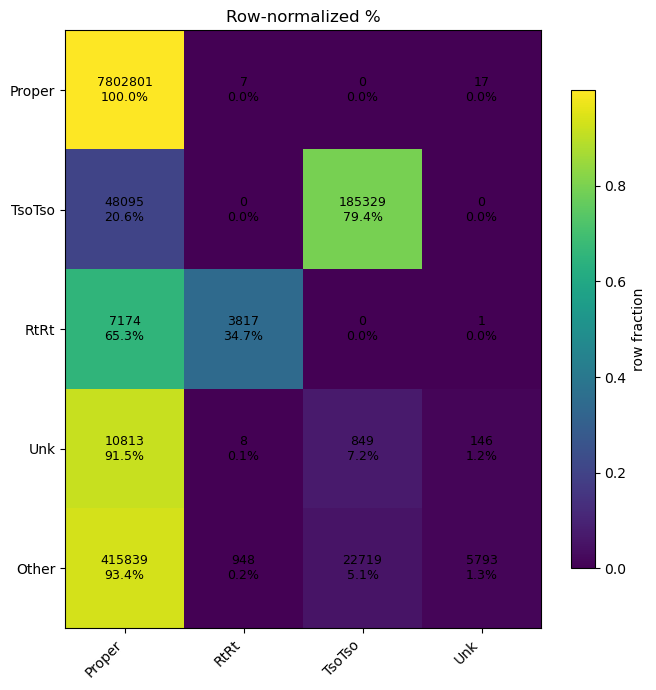

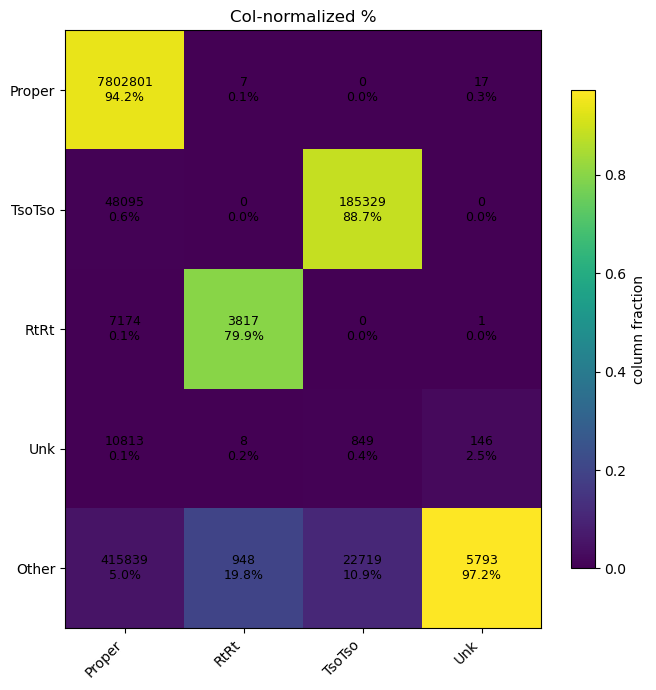

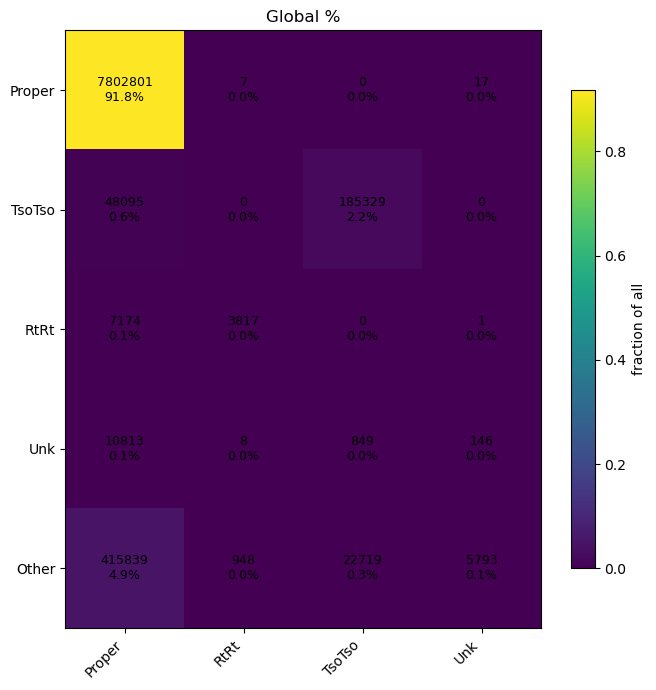

In [19]:
plot_heatmap(agg_ct_collapsed, normalize=None, title="All samples combined")
plot_heatmap(agg_ct_collapsed, normalize='row', title="Row-normalized %")#,  savepath="heat_row.svg")
plot_heatmap(agg_ct_collapsed, normalize='col', title="Col-normalized %")#,  savepath="heat_col.svg")
plot_heatmap(agg_ct_collapsed, normalize='all', title="Global %")#,          savepath="heat_all.svg")


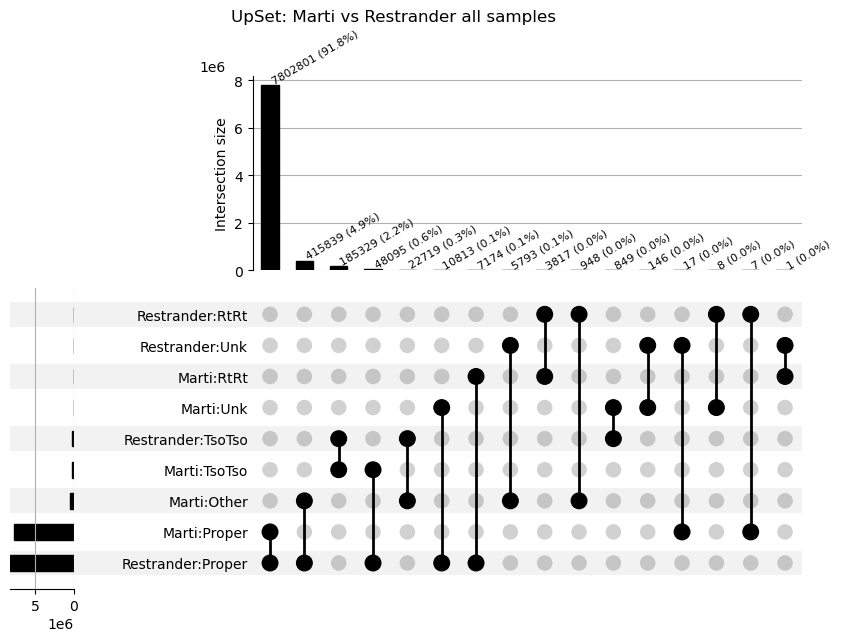

In [20]:
plot_upset_from_ct(agg_ct_collapsed, title="UpSet: Marti vs Restrander all samples")

Because most of the matches are Proper-Proper, they overshadow the other pairs, so we will also generate a version of the upset plot where with exclude that pair.

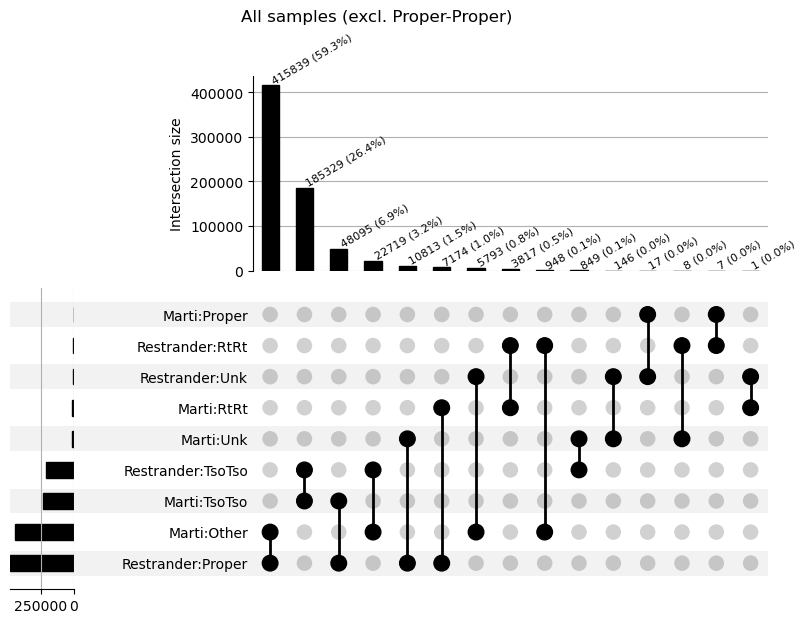

In [21]:
plot_upset_from_ct(agg_ct_collapsed, title="All samples (excl. Proper-Proper)",
                   exclude_pair=("Proper","Proper"))

We can also just view the data as a table. Before or after collapsing categories.

In [22]:
agg_ct

Restrander,Proper,RtRt,TsoTso,Unk
Marti,,,,
InternalAdapter,6779,804,2771,7
"InternalAdapter,MissingAdapter",200,1,5,69
"InternalAdapter,MissingAdapter,RetainedSMRTBell",13,0,0,4
"InternalAdapter,RetainedSMRTBell",515,89,306,0
InternalPrimingRT,83421,53,0,30
InternalPrimingTSO,85233,1,19617,151
MissingAdapter,35626,0,17,5476
"MissingAdapter,OnlyPolyA",567,0,0,5
OnlyPolyA,183264,0,0,0


In [23]:
agg_ct_collapsed

Restrander,Proper,RtRt,TsoTso,Unk
Marti,,,,
Proper,7802801,7,0,17
TsoTso,48095,0,185329,0
RtRt,7174,3817,0,1
Unk,10813,8,849,146
Other,415839,948,22719,5793


For a more detailled look at how the categories `marti` can identify but `restrander` does not, we can also color the upset plot bars for counts by category.

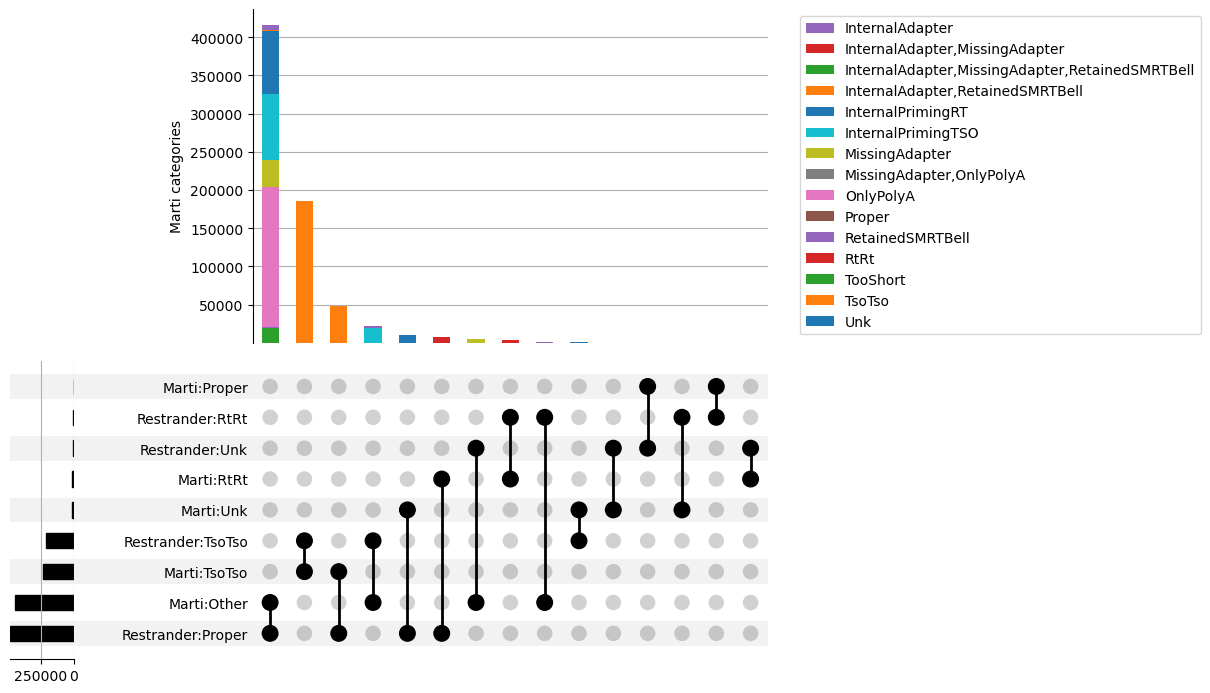

In [24]:
plot_upset_from_per_input_df(per_input_df)